In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Custom Functions

In [2]:
#this is used to display every column(instead of ...)
def display_entire_data(df):
    with pd.option_context('display.max_rows', 1000, 'display.max_columns', 1000):
        display(df)

In [3]:
def set_mean_rating_per_trainee(trainee_id):
    mean_val = temp_df.loc[temp_df['trainee_id']==trainee_id,'trainee_engagement_rating'].iloc[0]
    if np.isnan(mean_val):
        return full_df['trainee_engagement_rating'].mean()
    else:
        return mean_val

In [4]:
def data_visualization(data_frame, columns, target=None, plot_type="bar"):
    number_of_columns = len(columns)
    #setting subplots with size
    if(plot_type == 'hist'):
        num_of_rows = round(number_of_columns/4)
        f, ax = plt.subplots(num_of_rows, 4, figsize=(20, 6*num_of_rows))
    else:
        num_of_rows = round(number_of_columns/2)
        f, ax = plt.subplots(num_of_rows, 2, figsize=(20, 7*num_of_rows))
    
    #plotting graphs
    if plot_type == 'hist':
        for col_name, subplot in zip(columns, ax.flatten()):
            data_frame[col_name].fillna(data_frame[col_name].mean(), inplace=True)
            sns.distplot(data_frame[col_name], ax=subplot)
            
    elif(plot_type == 'bar'):
        for col_name, subplot in zip(columns, ax.flatten()):
            data_frame[col_name].fillna(data_frame[col_name].mode(), inplace=True)
            sns.countplot(data_frame[col_name], ax=subplot)
            
    elif(plot_type == 'box'):
        for col_name, subplot in zip(columns, ax.flatten()):
            sorted_vals = data_frame.groupby([col_name])[target].mean().sort_values()
            sns.boxplot(x=col_name, y=target, data=data_frame, ax=subplot, order=list(sorted_vals.index))
            for label in subplot.get_xticklabels():
                label.set_rotation(30)
        
        

# Basic Data description

In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.shape, test.shape

((73147, 16), (31349, 15))

In [6]:
display_entire_data(train.head()) # current data has limited columns so not req function

,id,program_id,program_type,program_duration,test_id,test_type,difficulty_level,trainee_id,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating,is_pass
0,9389_150,Y_1,Y,136,150,offline,intermediate,9389,M,Matriculation,3,24.0,5,N,1.0,0
1,16523_44,T_1,T,131,44,offline,easy,16523,F,High School Diploma,4,26.0,2,N,3.0,1
2,13987_178,Z_2,Z,120,178,online,easy,13987,M,Matriculation,1,40.0,1,N,2.0,1
3,13158_32,T_2,T,117,32,offline,easy,13158,F,Matriculation,3,NaN,4,N,1.0,1
4,10591_84,V_3,V,131,84,offline,intermediate,10591,F,High School Diploma,1,42.0,2,N,4.0,1


In [7]:
categorical_columns = train.select_dtypes(include=['object']).columns.tolist()
numerical_columns = train.select_dtypes(exclude=['object']).columns.tolist()
len(numerical_columns), len(categorical_columns)
#age_na_test_type = train.groupby(['test_type']).mean()

(8, 8)

# 1. Data Visualization

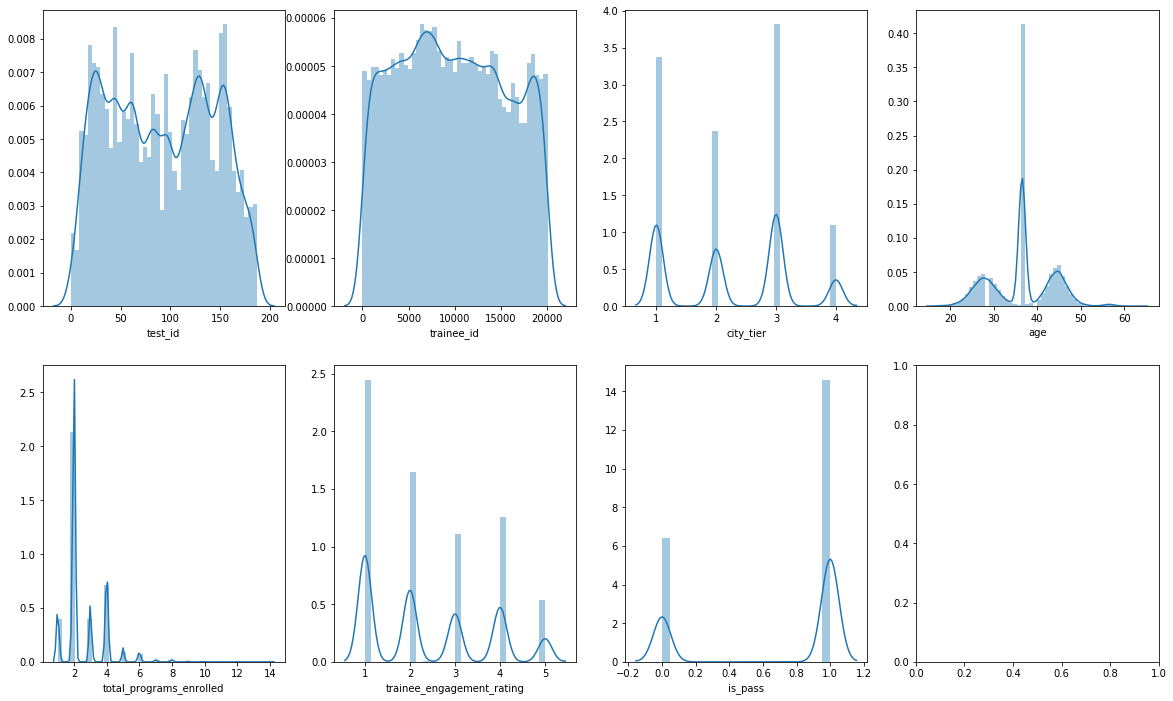

In [8]:
data_visualization(train, columns=numerical_columns[1:9], plot_type="hist")

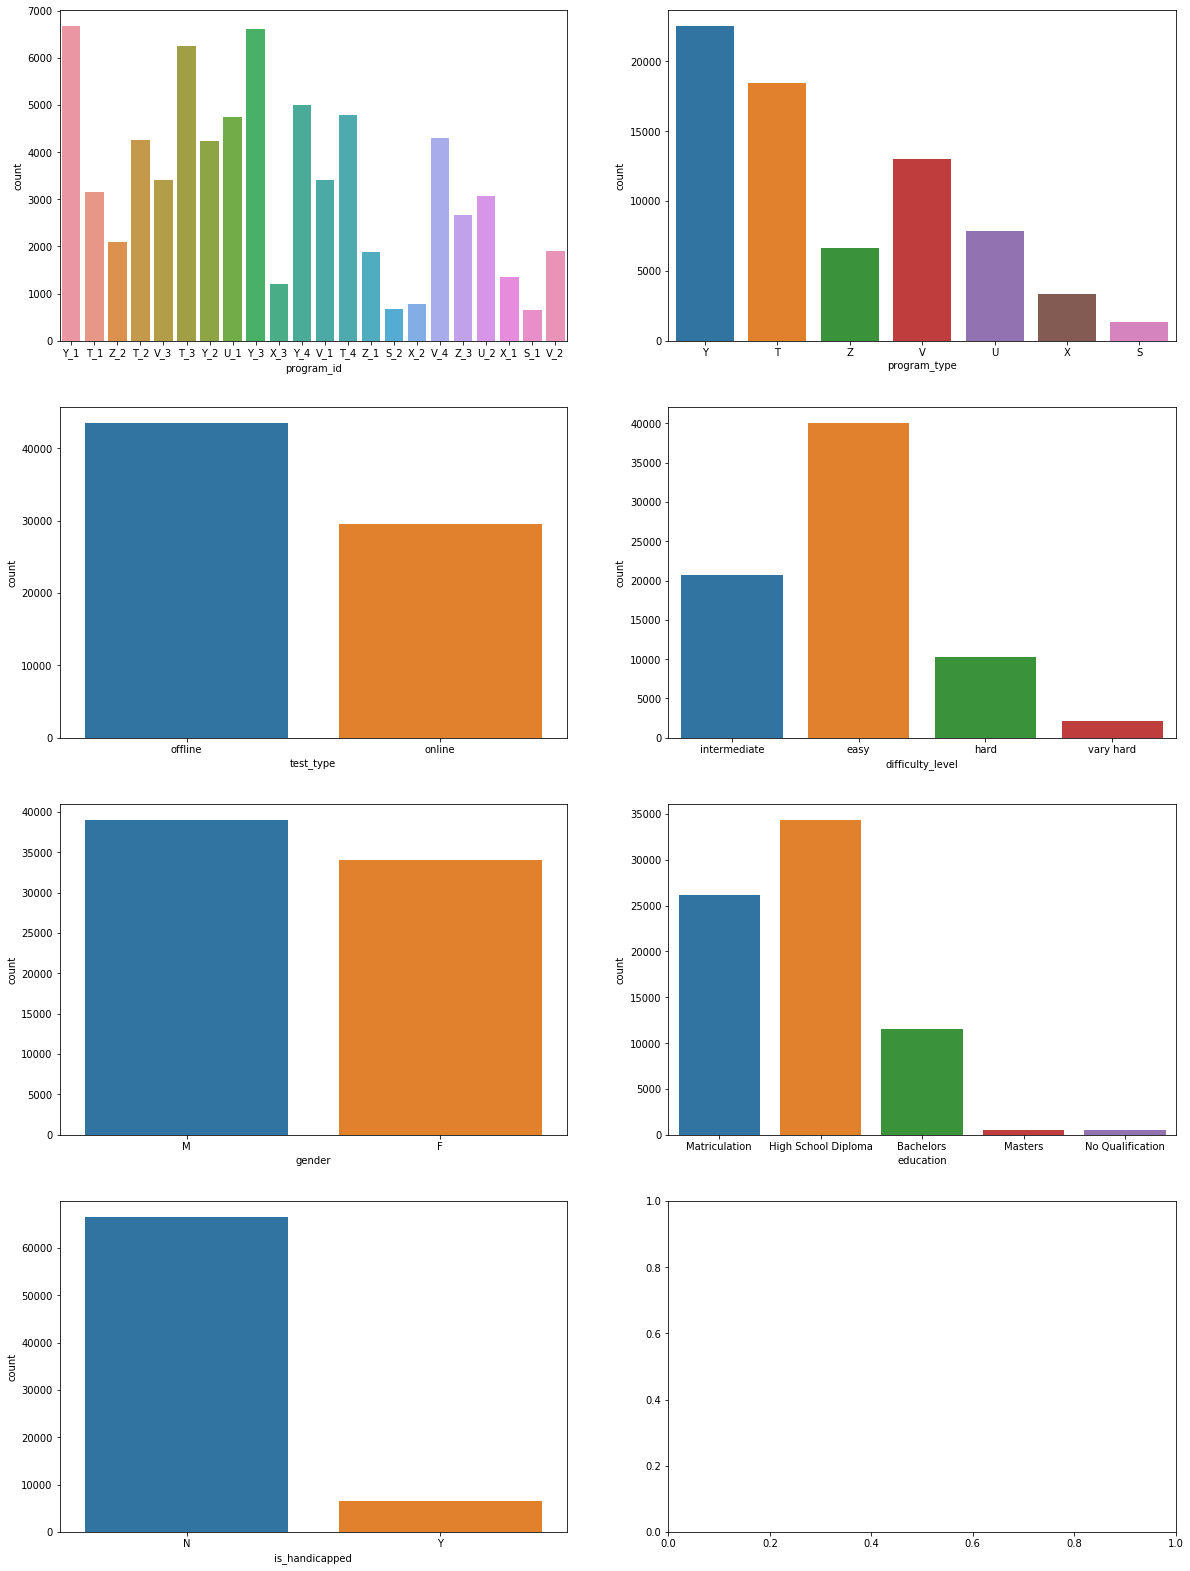

In [9]:
data_visualization(train, columns=categorical_columns[1:9],plot_type='bar')

In [10]:
#data_visualization(train, columns=numerical_columns[1:4], target="is_pass", plot_type='box')

# Feature Engineering

In [11]:
train['is_train'] = 1
test['is_train'] = 0
test['is_pass'] = 0
full_df = train.append(test)
full_df.isna().sum()

id                               0
program_id                       0
program_type                     0
program_duration                 0
test_id                          0
test_type                        0
difficulty_level                 0
trainee_id                       0
gender                           0
education                        0
city_tier                        0
age                          11791
total_programs_enrolled          0
is_handicapped                   0
trainee_engagement_rating       31
is_pass                          0
is_train                         0
dtype: int64

In [12]:
temp_avg = full_df.groupby('trainee_id')['trainee_engagement_rating'].mean()
temp_df = pd.DataFrame(temp_avg)
temp_df = temp_df.reset_index()

In [13]:
#full_df['trainee_engagement_rating'] = full_df['trainee_id'].apply(lambda col_val: set_mean_rating_per_trainee)
full_df['trainee_engagement_rating'].fillna(full_df['trainee_engagement_rating'].mode()[0], inplace=True)
full_df['age'].fillna(full_df['age'].mode()[0], inplace=True) # mode increaed accuracy %
#full_df.isna().sum()

In [14]:
full_df['test_id_count'] = full_df.groupby(['test_id'])['id'].transform('size')
full_df['trainee_id_program_type_count'] = full_df.groupby(['trainee_id', 'program_type'])['id'].transform('size')

# Encoding

## 1. Label encoding for ordinal category variables

In [15]:
#full_df['difficulty_level'].value_counts()
#full_df['education'].value_counts()
full_df['difficulty_level'] = full_df['difficulty_level'].map({'easy':0, 'intermediate':1, 'hard':2, 'vary hard':3})
label_encoder = preprocessing.LabelEncoder()
full_df['education'] = label_encoder.fit_transform(full_df['education'])
#label_encoder = 

## 2. one-hot encoding for ordinal category varibles

In [16]:
full_df.drop('id', axis=1, inplace=True)
full_df = pd.get_dummies(full_df)

# Modelling

In [17]:
#imbalanced target class
train = full_df[full_df['is_train']==1]
test_final = full_df[full_df['is_train']==0]
test_final.drop('is_pass', axis=1,inplace =True)
X = train.drop('is_pass', axis=1)
y = train['is_pass'].values

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [18]:
train_X, vald_X, train_y, vald_y = train_test_split(X, y, stratify=y) # stratify kfold is used as target variable is imbalance

In [19]:
train_X.head()

,program_duration,test_id,difficulty_level,trainee_id,education,city_tier,age,total_programs_enrolled,trainee_engagement_rating,is_train,...,program_type_V,program_type_X,program_type_Y,program_type_Z,test_type_offline,test_type_online,gender_F,gender_M,is_handicapped_N,is_handicapped_Y
54905,122,52,0,10904,1,3,33.000000,3,1.0,1,...,0,0,0,0,0,1,0,1,1,0
44457,134,112,2,7061,1,1,24.000000,4,3.0,1,...,0,1,0,0,1,0,0,1,1,0
44417,133,96,0,2838,0,1,41.000000,2,1.0,1,...,1,0,0,0,1,0,0,1,1,0
8779,134,111,2,15316,0,3,36.494033,2,2.0,1,...,0,1,0,0,1,0,0,1,1,0
35423,122,78,0,7588,1,3,36.494033,2,2.0,1,...,1,0,0,0,0,1,0,1,1,0


## 1. randomn forest model

In [20]:
rdm_model = RandomForestClassifier(random_state=15)
rdm_model.fit(train_X, train_y)
y_val_predictions_rdm = rdm_model.predict(vald_X)

In [21]:
roc_auc_score(vald_y,y_val_predictions_rdm )

0.6617035410692285

In [22]:
y_predictions = rdm_model.predict(test_final)

In [23]:
output_df = pd.DataFrame({'id':test.id, 'is_pass':y_predictions})

In [24]:
output_df.head()

,id,is_pass
0,1626_45,0
1,11020_130,1
2,12652_146,1
3,7038_72,0
4,888_71,0


In [25]:
output_df.to_csv("submission.csv", index=False)